In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import matplotlib.dates as mdates
import keras_tuner as kt
import pickle
import shap
import seaborn as sns
import scipy

from utils.ml_models import SOHyperModel
from utils.stochastic_processes import SOSawtooth
from utils.ml_models import DailyProfileModel, ConstantModel
from utils import data_prep
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
from matplotlib import rc, gridspec
from tqdm import tqdm

custom_dtype='float64'
tf.keras.backend.set_floatx(custom_dtype)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

2022-11-02 00:10:58.357999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 00:10:58.358029: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Setup

In [2]:
# Setup folder(s)
version= '2022-09-29'
    
# Define loss
def negloglik(p, rv_p):
    return -rv_p.log_prob(p)
  
# Prepare target/feature data and initial conditions Z
freq, features = data_prep.load_data()
ts, X, Y, Z = data_prep.prepare_data(freq, features, custom_dtype=custom_dtype)


# Split train, test and validation set
X_train = X.loc[:'2017'].sample(frac=1)
Z_train = Z.loc[X_train.index]
y_train = Y.loc[X_train.index]

X_val = X.loc['2018'].sample(frac=1)
Z_val = Z.loc[X_val.index]
y_val = Y.loc[X_val.index]

X_test = X.loc['2019'].sample(frac=1)
Z_test = Z.loc[X_test.index]
y_test = Y.loc[X_test.index] 

day_ahead_cols = X.filter(regex='day_ahead|hour|minute').columns
full_cols = X.columns

dp_model = DailyProfileModel()
c_model = ConstantModel()

2022-11-01 12:17:11.148938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 12:17:11.149037: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 12:17:11.149134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jokruse-ThinkPad-T480s): /proc/driver/nvidia/version does not exist
2022-11-01 12:17:11.193131: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_display_names = {'c_model':'Constant', 'dp_model':'Daily profile', 'ml_model_day_ahead':'Day-ahead', 'ml_model_full':'Full'}
param_display_names_units = {'tau':'Primary control \ntime scale $\\tau$ [min]', 'kappa':'Intrinsic secondary control \ntime scale $\kappa$ [min]',
                             'D':'Power fluctuation \nstrength $D$ [s$^{-3/2}$]', 'q':'Power step $q$ [s$^{-1}$]', 'r':'Power drift $r$ [s$^{-2}$]'}
param_display_names = {'tau':r'Primary control time scale $\tau$', 'kappa':'Intrinsic secondary control time scale $\kappa$', 'D':'Power fluctuation strength $D$',
                       'q':'Power step $q$', 'r':'Power drift $r$'}
param_display_names_short = {'tau':r'$\tau$ [min]', 'kappa':'$\kappa$ [min]', 'D':'$D$ [s$^{-3/2}$]', 'q':'$q$ [s$^{-1}$]', 'r':'$r$ [s$^{-2}$]'}
param_display_names_abs = {'tau':r'$\tau$', 'kappa':'$\kappa$', 'D':'$D$', 'q':'$|q|$', 'r':'$|r|$'}

param_rescaling = {'tau':1/60., 'kappa':1/60., 'D':1, 'q':1, 'r':1} 

param_names = ['s_theta_0','cov_theta_omega_0', 's_omega_0', # 0-4 is y0
                            'tau', 'kappa', 'D', 'q', 'r'] 

In [5]:
c_full, c_const, c_dp,c_data,c_q, c_tau, c_kappa, c_D,c_dh , c_r = sns.color_palette("colorblind", 10)

model_colors = {'Constant':c_const, 'Daily profile':c_dp, 'Day-ahead':c_dh, 'Full':c_full}
param_colors = {'tau':c_tau, 'kappa':c_kappa, 'D':c_D, 'q':c_q, 'r':c_r} 

In [6]:
input_cols = ['gen_other', 'gen_solar', 'gen_wind_on', 'gen_waste', 'gen_nuclear',
       'gen_biomass', 'gen_gas', 'gen_run_off_hydro', 'gen_oil',
       'gen_pumped_hydro', 'gen_other_renew', 'gen_reservoir_hydro',
       'gen_hard_coal', 'gen_wind_off', 'gen_geothermal', 'gen_lignite',
       'load', 'gen_coal_gas', 'total_gen', 'synchronous_gen', 'load_ramp',
       'total_gen_ramp', 'other_ramp', 'solar_ramp', 'wind_on_ramp',
       'waste_ramp', 'nuclear_ramp', 'biomass_ramp', 'gas_ramp',
       'run_off_hydro_ramp', 'oil_ramp', 'pumped_hydro_ramp',
       'other_renew_ramp', 'reservoir_hydro_ramp', 'hard_coal_ramp',
       'wind_off_ramp', 'geothermal_ramp', 'lignite_ramp', 'coal_gas_ramp',
       'forecast_error_wind_on', 'forecast_error_wind_off',
       'forecast_error_solar', 'forecast_error_total_gen',
       'forecast_error_load', 'forecast_error_load_ramp',
       'forecast_error_total_gen_ramp', 'forecast_error_wind_off_ramp',
       'forecast_error_wind_on_ramp', 'forecast_error_solar_ramp',
       'solar_day_ahead', 'wind_on_day_ahead', 'scheduled_gen_total',
       'prices_day_ahead', 'load_day_ahead', 'wind_off_day_ahead', 'month',
       'weekday', 'hour', 'load_ramp_day_ahead', 'total_gen_ramp_day_ahead',
       'wind_off_ramp_day_ahead', 'wind_on_ramp_day_ahead',
       'solar_ramp_day_ahead', 'price_ramp_day_ahead','gen_fossil_peat','fossil_peat_ramp',
       'hour_cos', 'hour_sin', 'minute_cos', 'minute_sin',
       'residual']


input_col_names = ['Generation other', 'Solar generation', 'Onshore wind generation', 'Waste generation', 'Nuclear generation',
       'Biomass generation', 'Gas generation', 'Run-off-river hydro generation', 'Oil generation',
       'Pumped hydro generation', 'Other renewable generation', 'Reservoir hydro generation',
       'Hard coal generation', 'Wind offshore generation', 'Geothermal generation', 'Lignite generation',
       'Load', 'Coal gas generation', 'Total generation', 'Synchronous generation', 'Load ramp',
       'Total generation ramp', 'Other ramp', 'Solar ramp', 'Onshore wind ramp',
       'Waste ramp', 'Nuclear ramp', 'Biomass ramp', 'Gas ramp',
       'Run-off-river hydro ramp', 'Oil ramp', 'Pumped hydro ramp',
       'Other renewable ramp', 'Reservoir hydro ramp', 'Hard coal ramp',
       'Offshore wind ramp', 'geothermal_ramp', 'Lignite ramp', 'Coal gas ramp',
       'Forecast error onshore wind', 'Forecast error offshore wind',
       'Forecast error solar', 'Forecast error total generation',
       'Forecast error load', 'Forecast error load ramp',
       'Forecast error \ngeneration ramp', 'Forecast error offshore wind ramp',
       'Forecast error onshore wind ramp', 'Forecast error solar ramp',
       'Solar day-ahead', 'Onshore wind day-ahead', 'Scheduled generation',
       'Prices day-ahead', 'Load day-ahead', 'Offshore wind day-ahead', 'Month',
       'Weekday', 'Hour', 'Load ramp day-ahead', 'Generation ramp day-ahead',
       'Offshore wind ramp day-ahead', 'Onshore wind ramp day-ahead',
       'Solar ramp day-ahead', 'Price ramp day-ahead', 'Fossil peat generation', 'Fossil peat ramp',
       'cos(hour)', 'sin(hour)', 'cos(minute)', 'sin(minute)',
       'Residual']

#Remark: The unit for prices varies among the areas. Here, we only display GB price data and thus use £ as a unit for simplicity.
# "input_col_names_units_general" contains the general unit of "currency" instead. 
input_col_names_units = ['Generation other [GW]', 'Solar generation [GW]', 'Onshore wind \ngeneration [GW]', 'Waste generation [GW]',
                         'Nuclear generation [GW]',
       'Biomass generation [GW]', 'Gas generation [GW]', 'Run-off-river \nhydro generation [GW]', 'Oil generation [GW]',
       'Pumped hydro \ngeneration [GW]', 'Other renewable generation [GW]', 'Reservoir \nhydro generation [GW]',
       'Hard coal \ngeneration [GW]', 'Wind offshore \ngeneration [GW]', 'Geothermal generation [GW]', 'Lignite generation [GW]',
       'Load [GW]', 'Coal gas generation [GW]', 'Total generation [GW]', 'Synchronous generation [GW]', 'Load ramp [GW/h]',
       'Total generation \nramp [GW/h]', 'Other ramp [GW/h]', 'Solar ramp [GW/h]', 'Onshore wind ramp [GW/h]',
       'Waste ramp [GW/h]', 'Nuclear ramp [GW/h]', 'Biomass ramp [GW/h]', 'Gas ramp [GW/h]',
       'Run-off-river \nhydro ramp [GW/h]', 'Oil ramp [GW/h]', 'Pumped hydro \nramp [GW/h]',
       'Other renewables ramp [GW/h]', 'Reservoir hydro \nramp [GW/h]', 'Hard coal \nramp [GW/h]',
       'Offshore wind ramp [GW/h]', 'geothermal_ramp [GW/h]', 'Lignite ramp [GW/h]', 'coal_gas_ramp [GW/h]',
       'Forecast error \nonshore wind [GW]', 'Forecast error \noffshore wind [GW]',
       'Forecast error \nsolar [GW]', 'Forecast error \ntotal generation [GW]',
       'Forecast error load [GW]', 'Forecast error \nload ramp [GW]',
       'Forecast error \ngeneration ramp [GW/h]', 'Forecast error \noffshore wind ramp [GW/h]',
       'Forecast error \nonshore wind ramp [GW/h]', 'Forecast error \nsolar ramp [GW/h]',
       'Solar day-ahead [GW]', 'Onshore wind \nday-ahead [GW]', 'Scheduled \ngeneration [GW]',
       'Prices day-ahead [€/MWh]', 'Load day-ahead [GW]', 'Offshore wind \nday-ahead [GW]', 'Month',
       'Weekday', 'Hour', 'Load ramp \nday-ahead [GW/h]', 'Generation ramp \nday-ahead [GW/h]',
       'Offshore wind \nramp day-ahead [GW/h]', 'Onshore wind \nramp day-ahead [GW/h]',
       'Solar ramp \nday-ahead [GW/h]', 'Price ramp \nday-ahead [€/MWh/h]','Fossil peat generation [GW]', 'Fossil peat ramp [GW/h]',
       'cos(hour)', 'sin(hour)', 'cos(minute)', 'sin(minute)',
       'Residual']

input_col_names_units_general = ['Generation other [GW]', 'Solar generation [GW]', 'Onshore wind generation [GW]', 'Waste generation [GW]', 'Nuclear generation [GW]',
       'Biomass generation [GW]', 'Gas generation [GW]', 'Run-off-river hydro generation [GW]', 'Oil generation [GW]',
       'Pumped hydro generation [GW]', 'Other renewable generation [GW]', 'Reservoir hydro generation [GW]',
       'Hard coal generation [GW]', 'Wind offshore generation [GW]', 'Geothermal generation [GW]', 'Lignite generation [GW]',
       'Load [GW]', 'Coal gas generation [GW]', 'Total generation [GW]', 'synchronous_gen [GW]', 'Load ramp [GW/h]',
       'Total generation ramp [GW/h]', 'Other ramp [GW/h]', 'Solar ramp [GW/h]', 'Onshore wind ramp [GW/h]',
       'Waste ramp [GW/h]', 'Nuclear ramp [GW/h]', 'Biomass ramp [GW/h]', 'Gas ramp [GW/h]',
       'Run-off-river hydro ramp [GW/h]', 'Oil ramp [GW/h]', 'Pumped hydro ramp [GW/h]',
       'Other renewables ramp [GW/h]', 'Reservoir hydro ramp [GW/h]', 'Hard coal ramp [GW/h]',
       'Offshore wind ramp [GW/h]', 'geothermal_ramp [GW/h]', 'Lignite ramp [GW/h]', 'coal_gas_ramp [GW/h]',
       'Forecast error onshore wind [GW]', 'Forecast error offshore wind [GW]',
       'Forecast error solar [GW]', 'Forecast error total generation [GW]',
       'Forecast error load [GW]', 'Forecast error load ramp [GW]',
       'Forecast error generation ramp [GW/h]', 'Forecast error offshore wind ramp [GW/h]',
       'Forecast error onshore wind ramp [GW/h]', 'Forecast error solar ramp [GW/h]',
       'Solar day-ahead [GW]', 'Onshore wind day-ahead [GW]', 'Scheduled generation [GW]',
       'Prices day-ahead [Currency/MWh]', 'Load day-ahead [GW]', 'Offshore wind day-ahead [GW]', 'Month',
       'Weekday', 'Hour', 'Load ramp day-ahead [GW/h]', 'Generation ramp day-ahead [GW/h]',
       'Offshore wind ramp day-ahead [GW/h]', 'Onshore wind ramp day-ahead [GW/h]',
       'Solar ramp day-ahead [GW/h]', 'Price ramp day-ahead [Currency/MWh/h]','Fossil peat generation [GW]', 'Fossil peat ramp [GW/h]',
       'cos(hour)', 'sin(hour)', 'cos(minute)', 'sin(minute)',
       'Residual']

input_col_names = dict(zip(input_cols, input_col_names))
input_col_names_units = dict(zip(input_cols, input_col_names_units))
input_col_names_units_general = dict(zip(input_cols, input_col_names_units_general))

input_rescale_factors = pd.Series(index=input_cols, data=1/1000)
input_rescale_factors.loc[['weekday', 'hour','month', 'prices_day_ahead','price_ramp_day_ahead']]=1

# Figure 1

In [7]:
syn_gen = np.zeros(900+8*60)
syn_gen[:4*60] = 300
syn_gen[4*60:900+4*60] = 190
syn_gen[-4*60:] = 50
syn_gen+= np.sin(np.arange(900+8*60)*(2*np.pi)/600)*5
syn_gen = pd.Series(syn_gen)
syn_gen_smooth = pd.Series(syn_gen).rolling(200, min_periods=1, win_type='gaussian', center=True).mean(std=30)

syn_load = np.zeros(900+8*60)
syn_load[:200] = np.arange(200)*0.15
syn_load[200:500] = syn_load[199]+np.arange(300)*0.23
syn_load[500:900] = syn_load[499]+np.arange(400)*0.11
syn_load[900:1380] = syn_load[899]+np.arange(480)*0.21
syn_load_smooth = -pd.Series(syn_load-300).rolling(150,min_periods=1, center=True).mean()

sawtooth_model=syn_load_smooth.copy()
sawtooth_model.iloc[:]=np.nan
sawtooth_model.iloc[0]=(syn_gen-syn_load_smooth).iloc[0]
sawtooth_model.iloc[4*60-1]=(syn_gen-syn_load_smooth).iloc[4*60-1]
sawtooth_model.iloc[4*60]=(syn_gen-syn_load_smooth).iloc[4*60]
sawtooth_model.iloc[4*60+900-1]=(syn_gen-syn_load_smooth).iloc[4*60+900-1]
sawtooth_model.iloc[4*60+900]=(syn_gen-syn_load_smooth).iloc[4*60+900]
sawtooth_model.iloc[8*60+900-1]=(syn_gen-syn_load_smooth).iloc[8*60+900-1]
sawtooth_model=sawtooth_model.interpolate('linear')


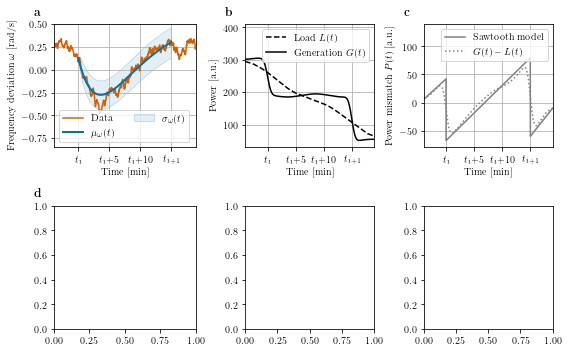

In [8]:
ts = tf.constant(np.arange(0,900, 1.).astype(custom_dtype))
st_process = SOSawtooth(ts)

params_mean = [[0.,0.126],144, 290,-0.0038,0.0000068]
params_sigma = [[0.000001,0.00000001,0.01], 144, 290, 0.02]

fig, axs = plt.subplots(2,3, figsize=(8,5),gridspec_kw={'width_ratios': [1.1,1,1]})
axs[0,0].autoscale(enable=True, axis='x', tight=True)

############################
step = '2018-08-28 23:00'
sol_mean = st_process.mean_t(*params_mean)[0]
sol_sigma = st_process.sigma_t(*params_sigma)[0]

axs[0,0].plot(np.arange(-60*4,900+60*4,1), freq.loc['2018-08-28 22:56:01':'2018-08-28 23:19:00'].values, label='Data', c=c_data)
axs[0,0].plot(np.arange(900), sol_mean, label=r'$\mu_{\omega}(t)$', lw=2, c=c_full)

axs[0,0].fill_between(np.arange(900), sol_mean-sol_sigma,sol_mean+sol_sigma, label='$\sigma_{\omega}(t)$', lw=0.5,  
                      facecolor='#0073b01d', edgecolor='#0073b05a')
axs[0, 0].grid()
axs[0,0].set_xlabel('Time [min]')
axs[0,0].set_xticks([0,300,600,900])
axs[0,0].set_xticklabels([r'$t_i$','$t_i$+5','$t_i$+10',r'$t_{i+1}$'])
#axs[k,l].set_ylabel(r'$\omega$ [a.u.]')
axs[0,0].legend( ncol=2)
axs[0,0].set_ylim([-0.85,0.5])
axs[0,0].set_ylabel('Frequency deviation $\omega$ [rad/s]')

################################

axs[0, 1].grid()
axs[0,1].set_xlabel('Time [min]')
axs[0,1].set_xticks([0,300,600,900])
axs[0,1].set_xticklabels([r'$t_i$','$t_i$+5','$t_i$+10',r'$t_{i+1}$'])
axs[0,1].set_xlim(axs[0,0].get_xlim())
axs[0,1].set_ylim([30,410])
axs[0,1].plot(np.arange(-60*4,900+60*4,1), syn_load_smooth.values,'--', label='Load $L(t)$', c='k')
axs[0,1].plot(np.arange(-60*4,900+60*4,1), syn_gen_smooth.values, label='Generation $G(t)$', c='k')
axs[0,1].legend( ncol=1)
axs[0,1].set_ylabel('Power [a.u.]')

axs[0,2].plot(np.arange(-60*4,900+60*4,1), sawtooth_model.values, label='Sawtooth model', c='gray')
axs[0,2].plot(np.arange(-60*4,900+60*4,1), (syn_gen_smooth-syn_load_smooth).values,':', label='$G(t)-L(t)$', c='gray')
axs[0, 2].grid()
axs[0,2].set_xlabel('Time [min]')
axs[0,2].set_xticks([0,300,600,900])
axs[0,2].set_xticklabels([r'$t_i$','$t_i$+5','$t_i$+10',r'$t_{i+1}$'])
axs[0,2].set_xlim(axs[0,0].get_xlim())
axs[0,2].legend( ncol=1)
axs[0,2].set_ylabel('Power mismatch $P(t)$ [a.u.]')
axs[0,2].set_ylim([-80,140])

####################################
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}']
for label, ax in zip(axs_labels, axs.flatten()):
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

plt.tight_layout()
plt.savefig('./figures/fig1_a-d.pdf', bbox_inches='tight')

# Figure 2

In [9]:
model_names = [ 'c_model','dp_model', 'ml_model_day_ahead', 'ml_model_full']
tmax_array = np.arange(6,15.1,3, dtype=int)*60
perf_logl = pd.DataFrame(index=y_test.index, columns=pd.MultiIndex.from_product([model_names, tmax_array]))


for tmax in np.arange(6,15.1,3, dtype=int)*60:
    for feature_types, cols in zip(['full', 'day_ahead'], [full_cols, day_ahead_cols]):
        
        print(tmax, feature_types)
        
        try:
            model_dir = './results/CE/version_{}/{}/{}/'.format(version,feature_types, tmax)
            
            # re-load best model via tuner
            with open(model_dir+'fixed_model_hps.pkl'.format(tmax), 'rb') as f:
                fixed_model_hps = pickle.load(f)
            tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                            directory=model_dir, oracle=kt.Oracle(),project_name="tuning")
            best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hps)
            model.load_weights(model_dir+'best_model/').expect_partial()
            model_name = 'ml_model_'+feature_types
            perf_logl.loc[:,(model_name, tmax)] = negloglik(y_test.iloc[:,:tmax],
                                                            model([X_test.loc[:,cols],Z_test]))
        except:
            continue
    dp_model.fit(y_train.append(y_val).iloc[:,:tmax]) 
    perf_logl.loc[:,('dp_model', tmax)] = negloglik(y_test.iloc[:,:tmax],
                                                    dp_model(X_test))
    c_model.fit(y_train.append(y_val).iloc[:,:tmax]) 
    perf_logl.loc[:,('c_model', tmax)] = negloglik(y_test.iloc[:,:tmax],
                                                    c_model(X_test))
    
perf_logl

360 full
INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/full/360/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/full/360/tuning/tuner0.json


2022-11-01 12:17:41.494152: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


360 day_ahead
INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/day_ahead/360/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/day_ahead/360/tuning/tuner0.json
540 full
INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/full/540/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/full/540/tuning/tuner0.json
540 day_ahead
INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/day_ahead/540/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/day_ahead/540/tuning/tuner0.json
720 full
INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/full/720/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/full/720/tuning/tuner0.json
720 day_ahead
INFO:tensorflow:Reloading Oracle from existing project ./results/CE/vers

c_model                                        \
                                  360         540          720          900   
2019-03-24 12:30:00+01:00 -308.518652 -489.445451  -667.995521  -799.736100   
2019-01-21 05:45:00+01:00 -256.827722 -340.809146  -460.597525  -348.383275   
2019-02-19 01:30:00+01:00 -239.885237 -359.762169  -518.344500  -733.531427   
2019-01-19 13:45:00+01:00  330.115303  877.084235  1844.361450  2170.138938   
2019-11-28 10:00:00+01:00  -61.109507 -199.896860  -322.081828  -399.426235   
...                               ...         ...          ...          ...   
2019-05-15 23:45:00+02:00 -244.490199 -236.173876  -321.228633  -288.696557   
2019-08-22 16:00:00+02:00 -284.110573 -441.309290  -636.917124  -850.084148   
2019-06-02 13:15:00+02:00 -278.289621 -377.821955  -448.064140  -564.318338   
2019-10-25 01:30:00+02:00 -177.490067 -357.422173  -537.732471  -641.738798   
2019-04-27 06:15:00+02:00 -320.236478 -507.301833  -697.199355  -899.951664   

                             dp_model                                         \
                                  360          540          720          900   
2019-03-24 12:30:00+01:00 -459.204432  -697.476691  -903.925293 -1088.600133   
2019-01-21 05:45:00+01:00 -137.583288  -212.594816  -349.286620  -415.579991   
2019-02-19 01:30:00+01:00 -159.620105  -306.438323  -504.541241  -684.584799   
2019-01-19 13:45:00+01:00  521.249265  1166.751293  2265.745401  2523.963224   
2019-11-28 10:00:00+01:00 -281.680610  -441.113540  -581.225778  -665.430789   
...                               ...          ...          ...          ...   
2019-05-15 23:45:00+02:00 -333.799125  -534.711558  -702.388329  -885.531480   
2019-08-22 16:00:00+02:00 -336.644468  -545.091398  -767.548259  -979.063699   
2019-06-02 13:15:00+02:00 -318.710431  -440.581514  -509.473210  -645.450685   
2019-10-25 01:30:00+02:00  -30.660935  -226.100557  -378.614789  -583.834112   
2019-04-27 06:15:00+02:00 -410.270345  -608.276458  -831.755958 -1050.751455   

                          ml_model_day_ahead                            \
                                         360          540          720   
2019-03-24 12:30:00+01:00        -509.325146  -650.964373 -1009.008559   
2019-01-21 05:45:00+01:00        -316.176439  -390.630115  -612.406355   
2019-02-19 01:30:00+01:00        -207.025411  -347.979480  -459.226074   
2019-01-19 13:45:00+01:00         430.094070  1716.092582  3736.355666   
2019-11-28 10:00:00+01:00        -284.765924  -383.164061  -569.871606   
...                                      ...          ...          ...   
2019-05-15 23:45:00+02:00        -395.326091  -594.485015  -752.239743   
2019-08-22 16:00:00+02:00        -427.850258  -662.511196  -874.091969   
2019-06-02 13:15:00+02:00        -408.308747  -532.412201  -710.856856   
2019-10-25 01:30:00+02:00        -232.566590  -372.765323  -475.421339   
2019-04-27 06:15:00+02:00        -467.218016  -688.742213  -897.339256   

                                       ml_model_full               \
                                   900           360          540   
2019-03-24 12:30:00+01:00  -988.450655   -479.021770  -711.724589   
2019-01-21 05:45:00+01:00  -651.625774   -280.353322  -384.621567   
2019-02-19 01:30:00+01:00  -821.345265   -408.337485  -618.030055   
2019-01-19 13:45:00+01:00  2973.876984    700.333996  1147.014376   
2019-11-28 10:00:00+01:00  -734.035941   -325.299044  -501.987605   
...                                ...           ...          ...   
2019-05-15 23:45:00+02:00  -834.963771   -427.892952  -579.806521   
2019-08-22 16:00:00+02:00 -1128.727798   -421.753269  -638.403050   
2019-06-02 13:15:00+02:00  -995.323504   -360.016826  -523.658794   
2019-10-25 01:30:00+02:00  -769.650499   -315.628767  -434.937626   
2019-04-27 06:15:00+02:00 -1012.147132   -471.339238  -676.692951   

                                                     
                                   720        

In [10]:
model_names = [ 'ml_model_day_ahead', 'ml_model_full']
tmax_array = np.arange(6,15.1,3, dtype=int)*60
perf_logl_diff = pd.DataFrame(index=y_test.index, columns=pd.MultiIndex.from_product([model_names, tmax_array]))

perf_logl_diff.loc[:, 'ml_model_day_ahead'] = ((perf_logl.loc[:, 'ml_model_day_ahead']  - perf_logl.loc[:, 'dp_model'])/perf_logl.loc[:, 'dp_model'].abs()).values
perf_logl_diff.loc[:, 'ml_model_full'] = ((perf_logl.loc[:, 'ml_model_full']  - perf_logl.loc[:, 'dp_model'])/perf_logl.loc[:, 'dp_model'].abs()).values

perf_logl_diff

ml_model_day_ahead                                \
                                         360       540       720       900   
2019-03-24 12:30:00+01:00          -0.109147  0.066687 -0.116252  0.091998   
2019-01-21 05:45:00+01:00          -1.298073 -0.837440 -0.753306 -0.567991   
2019-02-19 01:30:00+01:00          -0.296988 -0.135561  0.089815 -0.199771   
2019-01-19 13:45:00+01:00          -0.174878  0.470830  0.649062  0.178257   
2019-11-28 10:00:00+01:00          -0.010953  0.131371  0.019535 -0.103099   
...                                      ...       ...       ...       ...   
2019-05-15 23:45:00+02:00          -0.184323 -0.111786 -0.070974  0.057104   
2019-08-22 16:00:00+02:00          -0.270926 -0.215413 -0.138810 -0.152865   
2019-06-02 13:15:00+02:00          -0.281128 -0.208431 -0.395278 -0.542060   
2019-10-25 01:30:00+02:00          -6.585111 -0.648671 -0.255686 -0.318269   
2019-04-27 06:15:00+02:00          -0.138805 -0.132285 -0.078849  0.036740   

                          ml_model_full                                
                                    360       540       720       900  
2019-03-24 12:30:00+01:00     -0.043156 -0.020428  0.146414 -0.015582  
2019-01-21 05:45:00+01:00     -1.037699 -0.809177 -1.025201 -0.358209  
2019-02-19 01:30:00+01:00     -1.558183 -1.016817 -0.640975 -0.309637  
2019-01-19 13:45:00+01:00      0.343568 -0.016916 -0.265340  0.019544  
2019-11-28 10:00:00+01:00     -0.154851 -0.138001 -0.044750  0.168861  
...                                 ...       ...       ...       ...  
2019-05-15 23:45:00+02:00     -0.281888 -0.084335 -0.058041 -0.049037  
2019-08-22 16:00:00+02:00     -0.252815 -0.171185 -0.154476 -0.113032  
2019-06-02 13:15:00+02:00     -0.129605 -0.188563 -0.376676 -0.378793  
2019-10-25 01:30:00+02:00     -9.294166 -0.923647 -0.478955 -0.238461  
2019-04-27 06:15:00+02:00     -0.148850 -0.112476  0.007711  0.003225  

[21356 rows x 8 columns]

In [11]:
model_name = 'full'
cols = full_cols
model_dir = './results/CE/version_{}/{}/{}/'.format(version,'full', 900)

# re-load best model via tuner
with open(model_dir+'fixed_model_hps.pkl'.format(tmax), 'rb') as f:
    fixed_model_hps = pickle.load(f)
tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                directory=model_dir, oracle=kt.Oracle(),project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.load_weights(model_dir+'best_model/').expect_partial()

INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/full/900/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/full/900/tuning/tuner0.json


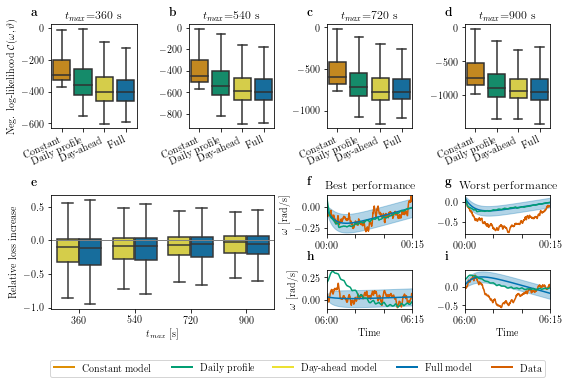

In [70]:
fig = plt.figure(figsize=(8,5.5))#,constrained_layout=True)

gs = plt.GridSpec(3, 4, figure=fig,height_ratios=[1,1.1,0.05])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}', r'\textbf{g}', r'\textbf{h}',r'\textbf{i}']


#################
# absolute performance boxplots

for i,tmax in enumerate(tmax_array):
    ax = fig.add_subplot(gs[0, i])
    data = perf_logl.loc[:,(slice(None),tmax)]
    data.columns= data.columns.droplevel(1)
    sns.boxplot(data=data.rename(columns=model_display_names),
                showfliers=False, ax=ax, palette=model_colors)
    ax.set_title(r'$t_{{max}}$={} s'.format(tmax))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
    ax.text(0.0, 1.0, axs_labels[i], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
    if i==0:
        ax.set_ylabel(r'Neg. log-likelihood $\mathcal C(\omega, \vartheta)$')

#####################
# relative performance depending on tmax

ax = fig.add_subplot(gs[1, :2])
data = perf_logl_diff.stack([0,1]).reset_index().rename(columns={'level_2':'tmax',
                                                                 'level_0':'time',
                                                                 'level_1':'model', 0:'performance'})
sns.boxplot(data=data.replace(model_display_names),
            x="tmax", y="performance", hue="model", showfliers=False, ax=ax,
            palette=model_colors)
plt.ylabel('Relative loss increase')
ax.text(0.0, 1.0, axs_labels[4], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
ax.set_xlabel('$t_{max}$ [s]')
ax.get_legend().remove()

ax.axhline(0, color='gray', linewidth=1)


#####################
# prediction examples

gs_sub = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,2:])
for j, time_of_day in enumerate(['00:00', '06:00']):
    inds=[]
    inds+=[perf_logl.loc[:,('ml_model_'+model_name,900)][perf_logl.index.strftime('%H:%M')==time_of_day].idxmin()]
    inds+=[perf_logl.loc[:,('ml_model_'+model_name,900)][perf_logl.index.strftime('%H:%M')==time_of_day].idxmax()]
    
    for i,ind in enumerate(inds):
            
        ax = fig.add_subplot(gs_sub[j, i])    
        y_ml_pred_mean = model([X_test.loc[[ind], cols], Z_test.loc[[ind]]]).mean().numpy()[0]
        y_ml_pred_std = model([X_test.loc[[ind], cols], Z_test.loc[[ind]]]).stddev().numpy()[0]

        y_dp_pred_mean = dp_model(X_test.loc[[ind]]).mean().numpy()[0]
        y_dp_pred_std = dp_model(X_test.loc[[ind]]).stddev().numpy()[0]

        ts_plot = np.arange(900)
        ax.plot(ts_plot, y_test.loc[ind].values, label='data', c=c_data)
        ax.plot(ts_plot, y_ml_pred_mean, label='ML model', c=c_full)
        ax.fill_between(ts_plot, y_ml_pred_mean-y_ml_pred_std, y_ml_pred_mean+y_ml_pred_std, alpha=0.3,edgecolor=c_full, facecolor=c_full)
        ax.plot(ts_plot, y_dp_pred_mean, label='Daily profile', c=c_dp)
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.set_xticks([0,300,600,900])
        ax.text(0.0, 1.0, axs_labels[5+j*2+i], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
        
        if j==0:
            if i==0:
                ax.set_title('Best performance')  
                ax.set_ylabel('$\omega$ [rad/s]')         
            if i==1:
                ax.set_title('Worst performance')   
            ax.set_xticklabels(['00:00','','','00:15'])
        else:
            ax.set_xlabel('Time')
            ax.set_xticklabels(['06:00','','','06:15'])
            if i==0:
                ax.set_ylabel('$\omega$ [rad/s]')
    

legend_elements = [plt.Line2D([0], [0], color=c_const, lw=2, label='Constant model'),
                   plt.Line2D([0], [0], color=c_dp, lw=2, label='Daily profile'),
                   plt.Line2D([0], [0], color=c_dh, lw=2, label='Day-ahead model'),
                   plt.Line2D([0], [0], color=c_full, lw=2, label='Full model'),
                   plt.Line2D([0], [0], color=c_data, lw=2, label='Data')
                   ]


plt.tight_layout()

ax = fig.add_subplot(gs[2, :])
ax.set_axis_off()
ax.legend(handles=legend_elements, bbox_to_anchor=(1.,5, 0,0), ncol=5)

plt.savefig('./figures/fig2.pdf', bbox_inches='tight')


# Figure 3

In [24]:
model_name = 'full'
cols = full_cols
tmax = 900
model_dir = './results/CE/version_{}/{}/{}/'.format(version,model_name, tmax)

# re-load best model via tuner
with open(model_dir+'fixed_model_hps.pkl'.format(tmax), 'rb') as f:
    fixed_model_hps = pickle.load(f)
tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                directory=model_dir, oracle=kt.Oracle(),project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best HPs: ', best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.load_weights(model_dir+'best_model/').expect_partial()

INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/full/900/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/full/900/tuning/tuner0.json
Best HPs:  {'lr': 0.001, 'dropout': 0.1, 'n_units': 64, 'n_layers': 2, 'activation_func': 'sigmoid'}


In [25]:
params = model.call_params(X_test.loc[:,cols].values).numpy()
param_names = model.st_process.param_names[2:]
params_frame = pd.DataFrame(data=params, index=X_test.index, columns=param_names)

p_daily_means = params_frame.groupby(params_frame.index.time).mean()
p_daily_std = params_frame.groupby(params_frame.index.time).std()
p_daily_q75 = params_frame.groupby(params_frame.index.time).quantile(0.90)
p_daily_q25 = params_frame.groupby(params_frame.index.time).quantile(0.10)

params_frame

,s_theta_0,cov_theta_omega_0,s_omega_0,tau,kappa,D,q,r
2019-08-18 03:45:00+02:00,2.296573,-0.002294,0.001,127.673755,2223.747828,0.009948,0.000182,2.365782e-07
2019-01-26 14:30:00+01:00,2.396144,-0.002394,0.001,93.540414,2192.759614,0.012977,-0.000913,1.325467e-06
2019-02-01 03:00:00+01:00,2.414130,-0.002412,0.001,58.236062,2240.556041,0.017776,-0.003851,5.139375e-06
2019-03-04 18:45:00+01:00,2.250629,-0.002248,0.001,345.492574,2270.070937,0.009008,-0.000677,1.095459e-06
2019-09-01 23:00:00+02:00,1.743887,-0.001742,0.001,58.220605,1558.108025,0.021530,-0.005308,7.615782e-06
...,...,...,...,...,...,...,...,...
2019-01-29 14:45:00+01:00,2.299498,-0.002297,0.001,140.685909,2183.781437,0.011115,-0.000197,7.240804e-07
2019-11-26 22:45:00+01:00,2.046550,-0.002044,0.001,127.407315,1975.218215,0.013062,0.000624,6.671526e-07
2019-08-29 06:45:00+02:00,2.341775,-0.002339,0.001,225.701541,2291.506832,0.010075,-0.000240,5.847265e-07
2019-02-02 17:45:00+01:00,2.270549,-0.002268,0.001,309.434969,2274.850505,0.009499,-0.000824,8.990070e-07


In [26]:
# Daily variations of the parameters
((p_daily_means.abs()-p_daily_means.abs().mean())/p_daily_means.abs().mean()).max()

s_theta_0            1.683241e-01
cov_theta_omega_0    1.683263e-01
s_omega_0            1.197656e-09
tau                  1.361126e+00
kappa                1.578819e-01
D                    6.149288e-01
q                    5.498116e+00
r                    4.122866e+00
dtype: float64

In [27]:
tau_ref = 120
kappa_ref = 183
D_ref = 0.007 
q_ref = 0.0042
r_ref=0.000009

In [30]:
# Predict with parameter model (this can take several minutes)

parameter_means = pd.DataFrame(columns=param_names+['kappa_scale', 'r_scale',
                                                    'q_scale','D_scale',
                                                    'performance','n_epochs',
                                                    'property', 'seed'])

i=0
for init_seed in tqdm(range(10)):
    for kappa_scale in [100,1000]:
        for r_scale in [1e-6,1e-5]:
            for q_scale in [1e-3,1e-2]:
                for D_scale in [0.01,0.1]: 

                
                    scaling_model_name = 'best_model_kappa{}_q{}_r{}_D{}_seed{}/'.format(kappa_scale,q_scale, r_scale,D_scale, init_seed)
                
                    pscalings = tf.constant([1,0,0.1,
                                                        0,kappa_scale,
                                                        D_scale,q_scale, r_scale],
                                                        dtype=custom_dtype)
                    n_epochs = np.loadtxt(model_dir+scaling_model_name+'n_epochs.txt')
                    tuner.hypermodel.param_scalings=pscalings
                    model = tuner.hypermodel.build(best_hps)
                    model.load_weights(model_dir+scaling_model_name).expect_partial() 
                    params = model.call_params(X_test.loc[:,cols].values).numpy()
                    parameter_means.loc[i, param_names] = np.abs(params).mean(0)
                    parameter_means.loc[i,'kappa_scale' ]= kappa_scale
                    parameter_means.loc[i,'r_scale' ]= r_scale
                    parameter_means.loc[i,'q_scale' ]= q_scale
                    parameter_means.loc[i,'D_scale' ]= D_scale
                    parameter_means.loc[i,'performance' ]= np.mean(negloglik(y_test.iloc[:,:tmax],
                                                                            model([X_test.loc[:,cols],Z_test])))
                    
                    parameter_means.loc[i,'n_epochs'] = n_epochs
                    parameter_means.loc[i,'seed'] = init_seed

                    if np.allclose(pscalings.numpy(), [1,0,0.1,0,100,0.01,0.001, 0.000001]):
                        parameter_means.loc[i,'property'] = 'main_model'
                    else:
                        parameter_means.loc[i,'property'] = 'scaling_variation'

                    i+=1



    #no scaling model
    scaling_model_name = 'best_model_no_scaling_seed{}/'.format(init_seed)

    pscalings = tf.constant([1,np.nan,1,np.nan,1,1,1, 1],
                            dtype=custom_dtype)
    n_epochs = np.loadtxt(model_dir+scaling_model_name+'n_epochs.txt')
    tuner.hypermodel.param_scalings=pscalings
    model = tuner.hypermodel.build(best_hps)
    model.load_weights(model_dir+scaling_model_name).expect_partial() 
    params = model.call_params(X_test.loc[:,cols].values).numpy()
    parameter_means.loc[i, param_names] = np.abs(params).mean(0)
    parameter_means.loc[i,'kappa_scale' ]= 1
    parameter_means.loc[i,'r_scale' ]= 1
    parameter_means.loc[i,'q_scale' ]= 1
    parameter_means.loc[i,'D_scale' ]= 1
    parameter_means.loc[i,'performance' ]= np.mean(negloglik(y_test.iloc[:,:tmax],
                                                            model([X_test.loc[:,cols],Z_test])))
    parameter_means.loc[i,'n_epochs'] = n_epochs             
    parameter_means.loc[i,'property'] = 'no_scaling'    
    parameter_means.loc[i,'seed'] = init_seed
    
    i+=1   
        
# Reference results
parameter_means.loc[i+1, param_names[3:]] = [tau_ref, kappa_ref, D_ref, q_ref, r_ref]
parameter_means.loc[i+1,'property'] = 'literature'   

parameter_means


100%|██████████| 10/10 [13:25<00:00, 80.53s/it]


,s_theta_0,cov_theta_omega_0,s_omega_0,tau,kappa,D,q,r,kappa_scale,r_scale,q_scale,D_scale,performance,n_epochs,property,seed
0,72.118082,0.072035,0.001,120.093929,1873.216033,0.014078,0.001064,0.000002,100,0.000001,0.001,0.01,-843.179168,48.0,main_model,0
1,147.074564,0.146926,0.001,110.478206,1494.674501,0.014553,0.001081,0.000002,100,0.000001,0.001,0.1,-845.156179,48.0,scaling_variation,0
2,20.850272,0.020619,0.001,105.12123,1478.099378,0.014404,0.001158,0.000002,100,0.000001,0.01,0.01,-846.837116,67.0,scaling_variation,0
3,0.009316,0.000009,0.001,97.828018,1283.673645,0.014844,0.001166,0.000002,100,0.000001,0.01,0.1,-844.692882,48.0,scaling_variation,0
4,29.546529,0.029501,0.001,121.539244,1638.094169,0.013956,0.001078,0.000002,100,0.00001,0.001,0.01,-848.428995,55.0,scaling_variation,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,58.408688,0.058343,0.001,118.018679,2055.27617,0.014293,0.001027,0.000002,1000,0.00001,0.001,0.1,-843.740739,45.0,scaling_variation,9
167,33.363712,0.033328,0.001,112.497352,2154.919793,0.01418,0.001254,0.000002,1000,0.00001,0.01,0.01,-846.533989,73.0,scaling_variation,9
168,33.944194,0.033894,0.001,104.891103,1836.900223,0.014356,0.001172,0.000002,1000,0.00001,0.01,0.1,-846.417265,40.0,scaling_variation,9
169,0.898861,0.204211,1.538302,14.75158,30.194398,4.135505,0.396808,0.007871,1,1,1,1,3259.949553,16.0,no_scaling,9


In [42]:
# relative to literature values
relative_parameter_means = parameter_means.copy()[parameter_means.property!='literature']     
relative_parameter_means.loc[:, param_names] /= parameter_means[parameter_means.property=='literature'].loc[:, param_names].values

relative_parameter_means

,s_theta_0,cov_theta_omega_0,s_omega_0,tau,kappa,D,q,r,kappa_scale,r_scale,q_scale,D_scale,performance,n_epochs,property,seed
0,NaN,NaN,NaN,0.093929,1690.216033,0.007078,-0.003136,-0.000007,100,0.000001,0.001,0.01,-843.179168,48.0,main_model,0
1,NaN,NaN,NaN,-9.521794,1311.674501,0.007553,-0.003119,-0.000007,100,0.000001,0.001,0.1,-845.156179,48.0,scaling_variation,0
2,NaN,NaN,NaN,-14.87877,1295.099378,0.007404,-0.003042,-0.000007,100,0.000001,0.01,0.01,-846.837116,67.0,scaling_variation,0
3,NaN,NaN,NaN,-22.171982,1100.673645,0.007844,-0.003034,-0.000007,100,0.000001,0.01,0.1,-844.692882,48.0,scaling_variation,0
4,NaN,NaN,NaN,1.539244,1455.094169,0.006956,-0.003122,-0.000007,100,0.00001,0.001,0.01,-848.428995,55.0,scaling_variation,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,NaN,NaN,NaN,3.420249,2137.73646,0.006599,-0.003147,-0.000007,1000,0.00001,0.001,0.01,-849.024023,64.0,scaling_variation,9
166,NaN,NaN,NaN,-1.981321,1872.27617,0.007293,-0.003173,-0.000007,1000,0.00001,0.001,0.1,-843.740739,45.0,scaling_variation,9
167,NaN,NaN,NaN,-7.502648,1971.919793,0.00718,-0.002946,-0.000007,1000,0.00001,0.01,0.01,-846.533989,73.0,scaling_variation,9
168,NaN,NaN,NaN,-15.108897,1653.900223,0.007356,-0.003028,-0.000007,1000,0.00001,0.01,0.1,-846.417265,40.0,scaling_variation,9


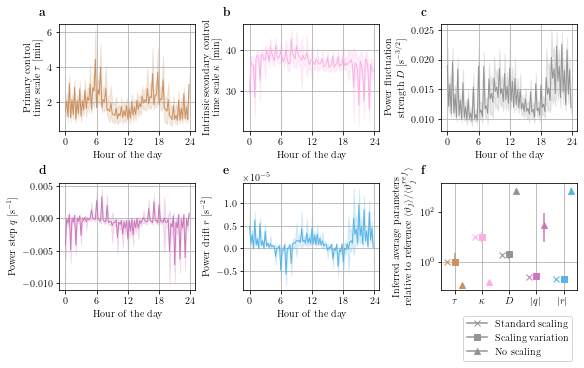

In [108]:
fig = plt.figure(figsize=(8,5.),constrained_layout=True)

gs = plt.GridSpec(2, 3, figure=fig)#,height_ratios=[1,1])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}']#, r'\textbf{h}',r'\textbf{i}']


######################
# daily profiles of parameters

n_interval_per_hour = 3600 // 900


for i,name in enumerate(param_names[3:]):
    
    ax = fig.add_subplot(gs[i//3,i%3])
    ax.plot(np.arange(24*n_interval_per_hour)/n_interval_per_hour,
            p_daily_means.loc[:,name].values*param_rescaling[name],
            c=param_colors[name], lw=1)
    ax.fill_between(np.arange(24*n_interval_per_hour)/n_interval_per_hour,
                    p_daily_q25.loc[:,name].values*param_rescaling[name],
                    p_daily_q75.loc[:,name].values*param_rescaling[name],
                    alpha=0.2, edgecolor=param_colors[name], facecolor=param_colors[name])
    ax.set_ylabel(param_display_names_units[name])
    ax.grid()
    ax.text(0.0, 1.0, axs_labels[i], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
    ax.set_xticks([0,6,12,18,24])
    ax.set_xlabel('Hour of the day')


#####################
# variation of scaling experiment

ax = fig.add_subplot(gs[1,2])

for i, prop in enumerate(['main_model', 'scaling_variation', 'no_scaling']):
        for j, param in enumerate(param_names[3:]):
                mean_val = relative_parameter_means[relative_parameter_means.property==prop].loc[:,param].abs().mean()
                min_val = relative_parameter_means[relative_parameter_means.property==prop].loc[:,param].abs().min()
                max_val = relative_parameter_means[relative_parameter_means.property==prop].loc[:,param].abs().max()
                
                ax.errorbar(x=j+(i-1)/3.7,y=mean_val, yerr=np.array([[mean_val-min_val],[max_val-mean_val]]),
                            fmt=['x','s', '^'][i], ecolor=param_colors[param], c=param_colors[param], ms=6)


ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([param_display_names_abs[param] for param in param_names[3:]])
ax.set_yscale('log')
ax.set_ylabel('Inferred average parameters \nrelative to reference '+ r'$\langle \vartheta_j \rangle / \langle \vartheta_j^{ref} \rangle$')
ax.text(0.0, 1.0, axs_labels[-1], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
ax.grid(axis='x')
ax.axhline(1, color='gray', linewidth=0.5)

legend_elements = [plt.Line2D([0], [0], marker='x', color=c_D, label='Standard scaling', markersize=6),
                   plt.Line2D([0], [0], marker='s', color=c_D, label='Scaling variation', markersize=6),
                   plt.Line2D([0], [0], marker='^', color=c_D, label='No scaling', markersize=6)
                   ]

# Create the figure
ax.legend(handles=legend_elements, bbox_to_anchor=(1,-0.2,0,0), ncol=1)

plt.savefig('./figures/fig3.pdf', bbox_inches='tight')


# Figure 4

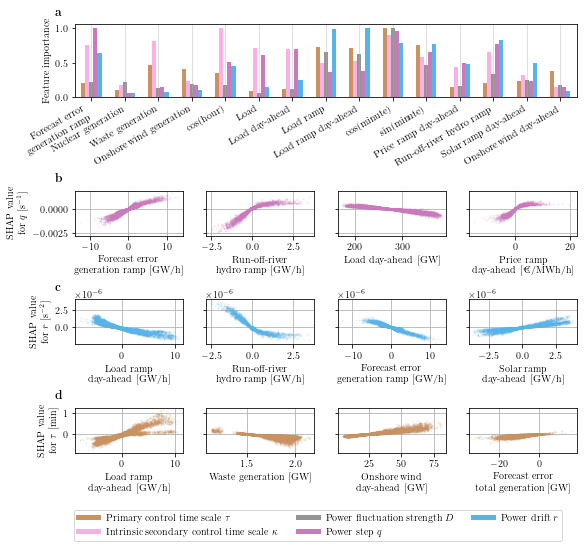

In [117]:
model_name = 'full'
cols = full_cols
tmax = 900
model_dir = './results/CE/version_{}/{}/{}/'.format(version,model_name, tmax)

fig = plt.figure(figsize=(8,7.5),constrained_layout=True)

gs = plt.GridSpec(5, 4, figure=fig,height_ratios=[1.3,0.8,0.8,0.8,0.1])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}', r'\textbf{g}' ,
              r'\textbf{h}',r'\textbf{i}',r'\textbf{j}',r'\textbf{k}', r'\textbf{l}', r'\textbf{m}']

# Number of most important features included from each parameter
n_features= 8

# selected features for dependency plots 
# 4 most important, without hour/minute features and double features due to actual/day-ahead removed

features_to_plot = {'q':['forecast_error_total_gen_ramp', 'run_off_hydro_ramp', 'load_day_ahead', 'price_ramp_day_ahead'],
                    'r':['load_ramp_day_ahead', 'run_off_hydro_ramp', 'forecast_error_total_gen_ramp', 'solar_ramp_day_ahead'],
                    'tau':['load_ramp_day_ahead', 'gen_waste',  'wind_on_day_ahead',  'forecast_error_total_gen']
                    }

##########################
# Feature importances

ax = fig.add_subplot(gs[0, :])

# Setup
shap_vals_abs=pd.DataFrame(index=cols, columns=param_names[3:])
important_features = []

# Create set of unique important features 
for i,param in enumerate(param_names[3:]):      
    shap_vals=pd.read_hdf(model_dir+'shap_values_{}_long.h5'.format(param))
    important_features+= list(shap_vals.abs().mean().sort_values(ascending=False).iloc[:n_features].index)
    shap_vals_abs.loc[:,param] = shap_vals.abs().mean()
        
important_features = np.unique(important_features)
shap_vals_abs = shap_vals_abs / shap_vals_abs.max()
shap_vals_abs = shap_vals_abs.loc[important_features].rename(index=input_col_names)

# make feature importance bar plots
g= sns.barplot(data=shap_vals_abs.unstack().reset_index(),
            x='level_1',y=0,hue='level_0',ax=ax,
            palette=param_colors, saturation=1, width=0.6)
g.legend_.remove()


# add axis labels and legend
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_xlabel('')
ax.set_ylabel('Feature importance')
legend_elements = [plt.Line2D([0], [0], color=par_color, lw=5, label=label) for par_color, label in zip(param_colors.values(),
                                                                                                        param_display_names.values())
                   ]

   
# add target names    
ax.grid(True, axis='x', alpha=0.5)
ax.text(0.0, 1.0, axs_labels[0], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

##########################
# Dependency plots

for i, (param, feature_list) in enumerate(features_to_plot.items()):

    shap_vals=pd.read_hdf(model_dir+'shap_values_{}_long.h5'.format(param))
    X_data = X_test.loc[shap_vals.index, cols]
    
    for j,feature in enumerate(feature_list):
        
        if feature!='':
            
            if j==0:
                ax = fig.add_subplot(gs[1+i, j]) 
            else:
                ax = fig.add_subplot(gs[1+i, j],sharey=ax_old)
                plt.setp(ax.get_yticklabels(), visible=False)   
            ax.plot(X_data.mul(input_rescale_factors).loc[:,feature], shap_vals.loc[:, feature]*param_rescaling[param], '.',
                    rasterized=True, c=param_colors[param], ms=2, alpha=0.1)
            ax.set_xlabel(input_col_names_units[feature])
            ax.grid()
            
            
            if j==0:
                ax.set_ylabel('SHAP value \nfor {}'.format(param_display_names_short[param]))
                ax.text(0.0, 1.0, axs_labels[1+i], transform=ax.transAxes + trans,
                        fontsize='large', va='bottom')
            ax_old = ax
        

###########################

ax = fig.add_subplot(gs[-1, :]) 
ax.set_axis_off()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.98,0), ncol=3, fontsize=10,columnspacing=2)

plt.savefig('./figures/fig4.pdf', bbox_inches='tight', dpi=300 )


# Figure 5

In [61]:
model_name = 'full'
cols = full_cols
tmax = 900
model_dir = './results/CE/version_{}/{}/{}/'.format(version,model_name, tmax)

# re-load best model via tuner
with open(model_dir+'fixed_model_hps.pkl'.format(tmax), 'rb') as f:
    fixed_model_hps = pickle.load(f)
tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                directory=model_dir, oracle=kt.Oracle(),project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.load_weights(model_dir+'best_model/').expect_partial()

INFO:tensorflow:Reloading Oracle from existing project ./results/CE/version_2022-09-29/full/900/tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./results/CE/version_2022-09-29/full/900/tuning/tuner0.json
{'lr': 0.001, 'dropout': 0.1, 'n_units': 64, 'n_layers': 2, 'activation_func': 'sigmoid'}


<AxesSubplot:>

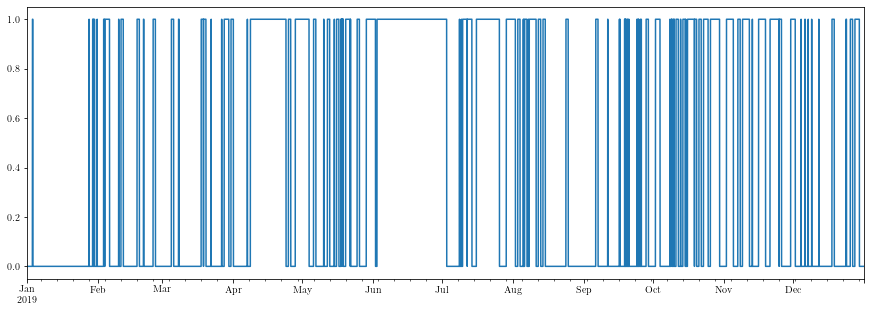

In [63]:
# plot intervals with nans
full_rolling_index = pd.date_range(start=y_test.sort_index().index[0],end=y_test.sort_index().index[-1], freq='15min')
y_test.reindex(full_rolling_index).isnull().any(1).astype(int).plot(figsize=(15,5))

In [64]:
# find largest non-nan interval

def true_intervals(bool_arr):
    """ Get intervals where bool_arr is true"""

    mask = np.concatenate([[True], ~bool_arr, [True]])
    interval_bounds = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1, 2)
    interval_sizes = interval_bounds[:, 1] - interval_bounds[:, 0]

    return interval_bounds, interval_sizes

full_rolling_index = pd.date_range(start=y_test.sort_index().index[0],end=y_test.sort_index().index[-1], freq='15min')
valid_bounds, valid_sizes = true_intervals(~y_test.reindex(full_rolling_index).isnull().any(1).values)
start,end= valid_bounds[ np.argsort(valid_sizes)[-2] ] # -1 is Jan 2019, but there was a long-lasting underfrequency event


In [65]:
# Construct rolling scenario for largest interval

full_rolling_test_index = y_test.reindex(full_rolling_index).iloc[start:end].index

X_rolling = X_test.loc[:,cols].reindex(index=full_rolling_test_index)
Z_rolling = Z_test.reindex(index=full_rolling_test_index)
y_rolling = y_test.reindex(index=full_rolling_test_index)
print(X_rolling.isnull().any(1).sum())

y_ml_pred_series_rolling = model.generate_sample([X_rolling, Z_rolling], rolling=True)
y_ml_pred_series_rolling = pd.DataFrame(index=X_rolling.index, data=y_ml_pred_series_rolling).sort_index()

y_ml_pred_series_rolling


0


100%|██████████| 1151/1151 [00:03<00:00, 313.87it/s]


,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
2019-08-25 00:15:00+02:00,0.081681,0.091101,0.082066,0.076582,0.087572,0.088861,0.093354,0.089846,0.075981,0.082246,...,0.121104,0.118595,0.123837,0.112745,0.098975,0.111938,0.119599,0.121165,0.126974,0.123265
2019-08-25 00:30:00+02:00,0.123265,0.130511,0.106109,0.097004,0.107039,0.099641,0.098815,0.106584,0.102488,0.101363,...,0.266307,0.236357,0.240402,0.241613,0.210183,0.174006,0.197035,0.202392,0.202204,0.190178
2019-08-25 00:45:00+02:00,0.190178,0.204349,0.219925,0.225674,0.234420,0.226512,0.232396,0.227278,0.209782,0.210077,...,0.105830,0.097605,0.104241,0.108579,0.088000,0.090354,0.083802,0.086016,0.076001,0.078661
2019-08-25 01:00:00+02:00,0.078661,0.073664,0.067646,0.027672,0.011708,0.018151,0.029868,0.043674,0.036469,0.036776,...,-0.262036,-0.251142,-0.211550,-0.206190,-0.205771,-0.195893,-0.198251,-0.179114,-0.154512,-0.167642
2019-08-25 01:15:00+02:00,-0.167642,-0.149907,-0.175810,-0.170698,-0.172979,-0.157661,-0.140287,-0.153876,-0.151284,-0.171612,...,0.146141,0.155329,0.133415,0.141304,0.144491,0.136082,0.126731,0.111996,0.092412,0.081949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-05 22:45:00+02:00,0.232919,0.229148,0.236337,0.232502,0.243025,0.226839,0.236898,0.247153,0.242304,0.246716,...,0.093302,0.100440,0.109520,0.128726,0.126476,0.141733,0.144043,0.146740,0.141381,0.129158
2019-09-05 23:00:00+02:00,0.129158,0.112779,0.121177,0.081307,0.123400,0.127318,0.125288,0.124981,0.083437,0.083603,...,-0.067516,-0.042054,-0.022555,0.025575,0.027138,-0.004455,0.030086,0.020164,0.016727,-0.009163
2019-09-05 23:15:00+02:00,-0.009163,-0.025615,-0.006531,0.000220,0.018944,0.007422,0.019596,0.008052,0.002993,-0.011186,...,0.132794,0.120323,0.129447,0.125310,0.124236,0.106566,0.125141,0.135090,0.138632,0.151816
2019-09-05 23:30:00+02:00,0.151816,0.166107,0.189841,0.190440,0.193724,0.165217,0.135927,0.126856,0.144898,0.149051,...,0.253231,0.262260,0.230211,0.210881,0.209415,0.230812,0.212510,0.216881,0.194949,0.209783


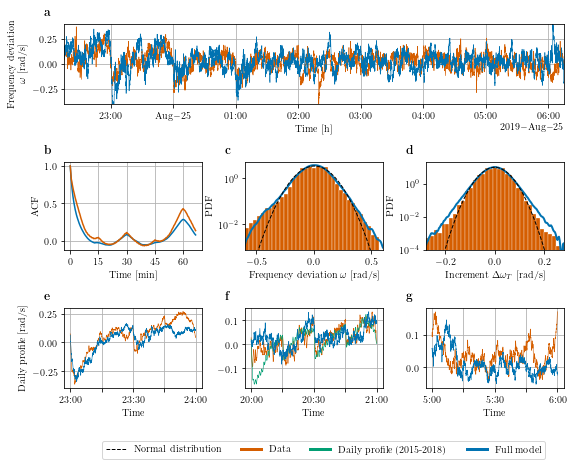

In [67]:
fig = plt.figure(figsize=(8,6))#,constrained_layout=True)

gs = plt.GridSpec(3, 3, figure=fig,height_ratios=[1,1.1,1])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}', r'\textbf{g}' ]#, r'\textbf{h}',r'\textbf{i}']

dp_model.fit(y_train.append(y_val)) 

############
# time series examples

ax = fig.add_subplot(gs[0, :])
n_hours = 8
plot_ind = pd.date_range(start=y_ml_pred_series_rolling.index[0],
                         end=y_ml_pred_series_rolling.index[4*n_hours],
                         freq='1s')[:-1]
ax.plot(plot_ind, y_rolling.iloc[:4*n_hours].values.flatten(), label='data', lw=0.6, c=c_data)
ax.plot(plot_ind, y_ml_pred_series_rolling.iloc[:4*n_hours].values.flatten(), label='model (rolling)', lw=0.6, c=c_full)
ax.grid()
ax.set_xlim([plot_ind[0],plot_ind[-1]])
ax.set_ylim([-0.4,0.4])
ax.set_xlabel('Time [h]')
ax.set_ylabel('Frequency deviation \n$\omega$ [rad/s]')
ax.text(0.0, 1.0, axs_labels[0], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


############
# ACF

ax = fig.add_subplot(gs[1, 0])
acf_all = sm.tsa.acf(y_ml_pred_series_rolling.values.flatten(), missing='raise', nlags=4000)
acf_data=sm.tsa.acf(y_rolling.sort_index().values.flatten(), missing='conservative', nlags=4000)
ax.plot(acf_all, label='using model sample (rolling)', c=c_full)
ax.plot(acf_data, label='from data', c=c_data)
ax.set_ylabel('ACF')
ax.set_xticks([0,900,1800,2700,3600])
ax.set_xticklabels([0,15,30,45,60])
ax.set_xlabel('Time [min]')
ax.text(0.0, 1.0, axs_labels[1], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
ax.grid()

############
# freq hist

ax = fig.add_subplot(gs[1, 1])
binrange=[-0.6,0.6]

sns.histplot(data=y_rolling.values.flatten(), log_scale=(False,True),ax=ax,bins=35, label='from data',
             stat='density', element='bars', facecolor=c_data, edgecolor='white', binrange=binrange)
sns.kdeplot(data=y_ml_pred_series_rolling.values.flatten(), log_scale=(False,True),ax=ax,
            label='from sample', color=c_full, lw=2)


mu, std = scipy.stats.norm.fit(y_rolling.values.flatten())
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
ax.plot(x, p,'--', c='black', linewidth=1)

ax.set_xlim(binrange)
ax.set_ylim([8e-4,5e0])
ax.set_xlabel('Frequency deviation $\omega$ [rad/s]')
ax.set_ylabel('PDF')


ax.text(0.0, 1.0, axs_labels[2], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

############
# increment hist

ax = fig.add_subplot(gs[1, 2])
lag = 10
binrange=[-0.28,0.28]

data = y_ml_pred_series_rolling.values.flatten()
sns.kdeplot(data=data[lag:]-data[:-lag], log_scale=(False,True),ax=ax, label='from sample', color=c_full, lw=2)

data = y_rolling.values.flatten()
sns.histplot(data=data[lag:]-data[:-lag], log_scale=(False,True),ax=ax,bins=35, label='from data',
             stat='density', element='bars', facecolor=c_data, edgecolor='white', binrange=binrange)

mu, std = scipy.stats.norm.fit(data=data[lag:]-data[:-lag])
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
l0,=ax.plot(x, p,'--', c='black', linewidth=1)

ax.set_xlim(binrange)
ax.set_ylim([1e-4,2e1])
ax.set_xlabel(r'Increment $\Delta \omega_{T}$ [rad/s]')
ax.set_ylabel('PDF')


ax.text(0.0, 1.0, axs_labels[3], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

############
# daily profiles

dp_ml_rolling = y_ml_pred_series_rolling.groupby(y_ml_pred_series_rolling.index.time).mean().values.flatten()
dp_data = y_rolling.groupby(y_rolling.index.time).mean().values.flatten()

for i,h in enumerate([23,20, 5]):

    htime = h*3600
    
    ax = fig.add_subplot(gs[2, i])
    
    if i==1:
        l1,=ax.plot(np.arange(3600)/3600,dp_data[htime:htime+3600],  lw=0.6, c=c_data)
        l2,=ax.plot(np.arange(3600)/3600,dp_model.dp_means.iloc[h*4:(h+1)*4].values.flatten(),lw=0.6,  c=c_dp)
        l3,=ax.plot(np.arange(3600)/3600, dp_ml_rolling[htime:htime+3600],  label='model',lw=0.6, c=c_full)
    else:
        ax.plot(np.arange(3600)/3600,dp_data[htime:htime+3600], lw=0.6, c=c_data)
        ax.plot(np.arange(3600)/3600, dp_ml_rolling[htime:htime+3600],  lw=0.6, c=c_full)
        
    ax.set_xticks([0,0.25,0.5, 0.75,1])
    ax.set_xticklabels(['{:2}:00'.format(h),'', '{:2}:30'.format(h),'','{:2}:00'.format(h+1)])
    ax.grid()
    #ax.set_xlim([0,24])
    ax.set_xlabel('Time')
    ax.text(0.0, 1.0, axs_labels[4+i], transform=ax.transAxes + trans,
                fontsize='large', va='bottom')
    if i==0:
        ax.set_ylabel('Daily profile [rad/s]')

############
plt.tight_layout(w_pad=0.3)


legend_elements = [plt.Line2D([0], [0], color='black', lw=1, linestyle='--', label='Normal distribution'),
                   plt.Line2D([0], [0], color=c_data, lw=3, label='Data'),
                   plt.Line2D([0], [0], color=c_dp, lw=3, label='Daily profile (2015-2018)'),
                   plt.Line2D([0], [0], color=c_full, lw=3, label='Full model')
                   ]
ax.legend(handles=legend_elements, ncol=4,bbox_to_anchor=(0.9,-0.6,0,0))
plt.savefig('./figures/fig5_d.pdf', bbox_inches='tight')
